# Lactate Discordance Project
## Classifier Validation and Analysis
### C.V. Cosgriff, MIT Critical Data

In this notebook we examine the two models we found via grid search and then validate them on the held out test sets. We also examine their feature importance matrices.

The notebook will be structured as follows:
* Low APACHE IVa cohort classifier
    * Load training and test data
    * Train model with CV selected hyperparameters
    * Calculate ROC on heldout test set
    * Determine importance matrix
* High APACHE IVa cohort classifier
    * Load training and test data
    * Train model with CV selected hyperparameters
    * Calculate ROC on heldout test set
    * Determine importance matrix

## Step 0: Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import sem
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

marker = ['v','o','d','^','s','>','+']
ls = ['-','-','-','-','-','s','--','--']

# configure matplotlib
plt.rcParams.update({'font.size': 22})
plt.style.use('classic')
plt.rcParams.update({'figure.max_open_warning': 0})

# configure jupyter for using matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Step 1: Low APACHE IVa Classifier

The hyperparameter search revealed the following as the optimal classifier in this cohort was:

```python
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=6, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)
```

We'll first load the data.

In [2]:
X_train = np.load('./X_train_la.npy')
y_train = np.load('./y_train_la.npy')
X_test = np.load('./X_test_la.npy')
y_test = np.load('./y_test_la.npy')

Now we train the optimal classifier on the original training set.

In [3]:
la_xgb = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
       colsample_bytree = 0.5, gamma = 0, learning_rate = 0.01, max_delta_step = 0,
       max_depth = 6, min_child_weight = 6, missing = None, n_estimators = 1000,
       n_jobs = 1, nthread = None, objective = 'binary:logistic', random_state = 0,
       reg_alpha= 0 , reg_lambda = 1, scale_pos_weight = 1, seed = None,
       silent = True, subsample = 0.6)
la_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=6, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

And now we can validate it on the held out test set.

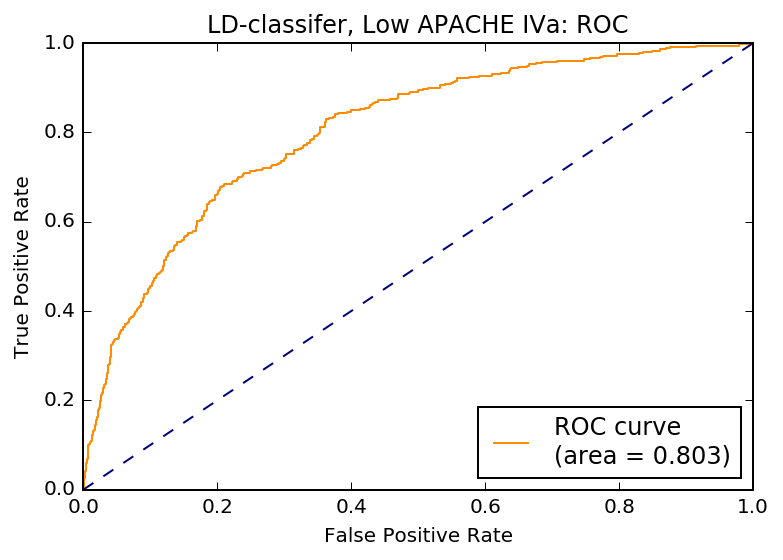

In [4]:
y_hat_probs = la_xgb.predict_proba(X_test)
roc = roc_curve(y_test, y_hat_probs[:, 1])
auc = roc_auc_score(y_test, y_hat_probs[:, 1])
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'LD-classifer, Low APACHE IVa')
plt.legend(loc = "lower right")
plt.savefig('./ld-clssifier-lowAPACHE-ROC.png')
plt.show()

We achieve an AUC of 0.800, beating the CV predicted AUC. This is a great AUC for this preliminary study. We can use bootstrapping to generate a CI for this AUC.

In [5]:
n_bootstraps = 2000
rng_seed = 42
rng = np.random.RandomState(rng_seed)
bootstrapped_auc = []

for i in range(n_bootstraps):
    indices = rng.random_integers(0, len(y_hat_probs) - 1, len(y_hat_probs))
    auc = roc_auc_score(y_test[indices], y_hat_probs[indices, 1])
    bootstrapped_auc.append(auc)

sorted_scores = np.array(bootstrapped_auc)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

print("Confidence interval: [{:0.3f} - {:0.3f}]".format(confidence_lower, confidence_upper))

/Users/cosgriffc/anaconda2/envs/DL_36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 3300 + 1) instead
  import sys


Confidence interval: [0.779 - 0.827]


Finally, we may examine the feature importance matrix. We'll load up the cohort data to get the column names, generate the mapping, and plot the importance matrix for the top 20 features.

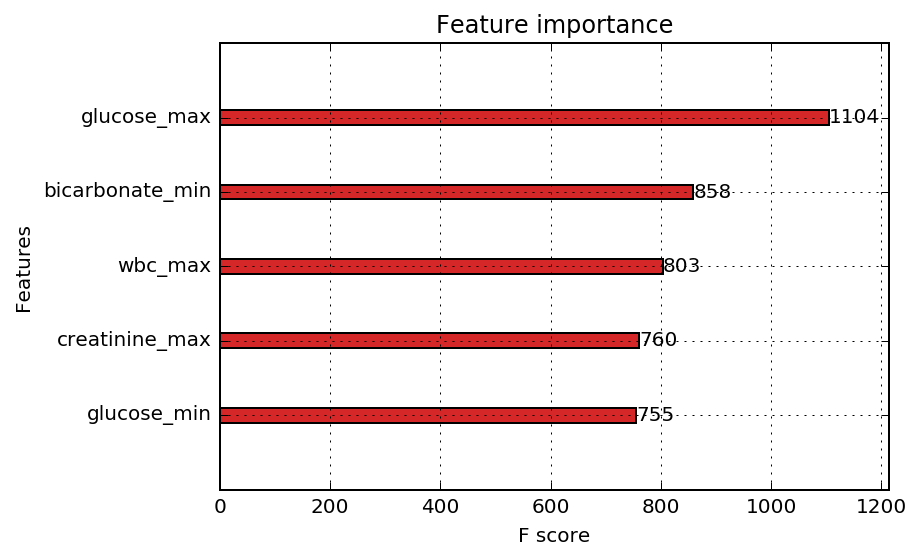

In [6]:
feature_names = pd.read_csv('./la_cohort.csv').set_index('patientunitstayid').columns
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: v for k, v in la_xgb.get_booster().get_fscore().items()}
plot_importance(imp_matrix, max_num_features = 5, color = tableau20[6])
plt.savefig('./la_imp.png', bbox_inches = "tight")
plt.show()

## Step 2: High APACHE IVa Classifier

The hyperparameter search revealed the following as the optimal classifier in this cohort was:

```python
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)
```

We'll first load the data.

In [7]:
X_train = np.load('./X_train_ha.npy')
y_train = np.load('./y_train_ha.npy')
X_test = np.load('./X_test_ha.npy')
y_test = np.load('./y_test_ha.npy')

Again, we train the optimal classifier on the original training set.

In [8]:
ha_xgb = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
       colsample_bytree = 1, gamma = 0, learning_rate = 0.05, max_delta_step = 0,
       max_depth = 3, min_child_weight = 10, missing = None, n_estimators = 500,
       n_jobs = 1, nthread = None, objective = 'binary:logistic', random_state = 0,
       reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, seed = None,
       silent=True, subsample=0.6)
ha_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

Then validate this classifier on the held out test set.

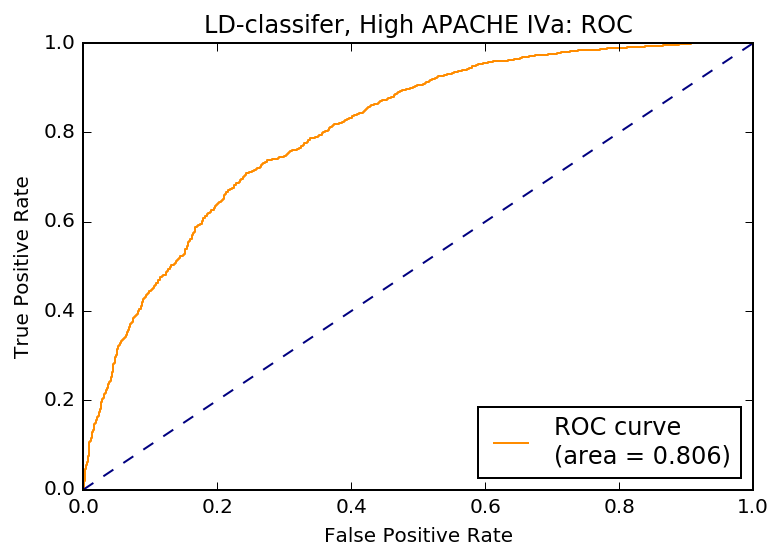

In [9]:
y_hat_probs = ha_xgb.predict_proba(X_test)
roc = roc_curve(y_test, y_hat_probs[:, 1])
auc = roc_auc_score(y_test, y_hat_probs[:, 1])
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'LD-classifer, High APACHE IVa')
plt.legend(loc = "lower right")
plt.savefig('./ld-clssifier-highAPACHE-ROC.png')
plt.show()

We achieve an AUC of 0.806, beating the CV predicted AUC. This is a great AUC for this preliminary study. We can use bootstrapping to generate a CI for this AUC.

In [10]:
n_bootstraps = 2000
rng_seed = 42
rng = np.random.RandomState(rng_seed)
bootstrapped_auc = []

for i in range(n_bootstraps):
    indices = rng.random_integers(0, len(y_hat_probs) - 1, len(y_hat_probs))
    auc = roc_auc_score(y_test[indices], y_hat_probs[indices, 1])
    bootstrapped_auc.append(auc)

sorted_scores = np.array(bootstrapped_auc)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

print("Confidence interval: [{:0.3f} - {:0.3f}]".format(confidence_lower, confidence_upper))

/Users/cosgriffc/anaconda2/envs/DL_36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 3060 + 1) instead
  import sys


Confidence interval: [0.791 - 0.822]


Finally, we may examine the feature importance matrix. We'll load up the cohort data to get the column names, generate the mapping, and plot the importance matrix for the top 20 features.

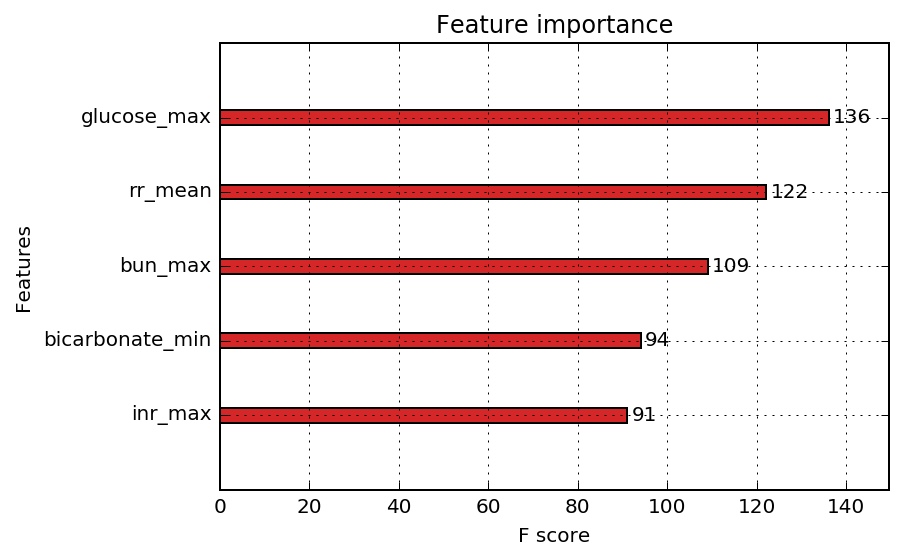

In [11]:
feature_names = pd.read_csv('./ha_cohort.csv').set_index('patientunitstayid').columns
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: v for k, v in ha_xgb.get_booster().get_fscore().items()}
plot_importance(imp_matrix, max_num_features = 5, color = tableau20[6])
plt.savefig('./ha_imp.png', bbox_inches = "tight")
plt.show()